In [21]:
import torch

import pandas as pd
import numpy as np

from torch import nn as nn
from matplotlib import pyplot as plt

from joblib import load
from ml_correction import BuoyDataset, SimpleMLP, LessSimpleMLP, add_cyclic_time

In [22]:
def rmse(pred, target):
    return np.sqrt(np.mean((pred - target)**2))

#### Prepare data

In [24]:
path_data = "//kant.uio.no/geo-geofag-u1/matsip/PHD_BioGov/Courses/GEO9300_autumn2025/GEO9300_project/GEO9300_project/dataset/"
buoys_df = pd.read_csv(f"{path_data}prepared_buoy_data.csv", index_col=[0, 1])
path_models = "models/"

X_scaler = load(f'{path_models}X_train_scaler.bin')

FileNotFoundError: [Errno 2] No such file or directory: 'models/X_train_scaler.bin'

In [ ]:
kvs = buoys_df.loc['KVS_SvalMIZ_10'].dropna()
kvs = kvs.set_index(pd.to_datetime(kvs.index))
kvs['residuals'] = kvs['temp_air'] - kvs['arome_t2m']
kvs['hour'] = kvs.index.hour
kvs['doy'] = kvs.index.day_of_year

X_data = kvs[['arome_t2m', 'sic', 'hour', 'doy']]
y_data = kvs[['residuals']]

X_test_time = X_data[['hour', 'doy']]
X_test = X_data.drop(['hour', 'doy'], axis = 1)

X_test_time = add_cyclic_time(X_test_time.copy())

X_test = X_scaler.transform(X_test)
X_test = np.concatenate(
    [X_test, X_test_time[['hour_sin', 'hour_cos', 'day_sin', 'day_cos']]], axis = 1
)

test_dataset = BuoyDataset(X_test, y_data.to_numpy())
test_loader = torch.utils.data.DataLoader(test_dataset,  batch_size = 1, shuffle = False)

NameError: name 'X_scaler' is not defined

#### prepare models

In [ ]:
model = torch.load(f"{path_models}dnn.pt", weights_only=False)
model.eval()

SimpleMLP(
  (network): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [ ]:
fancy_model = torch.load(f"{path_models}diamond_dnn.pt", weights_only=False)
fancy_model.eval()

#### Validate model

In [ ]:
test_preds = np.zeros(y_data.shape[0])
test_preds_fancy = np.zeros_like(test_preds)
with torch.no_grad():
    for i, (X, y) in enumerate(test_loader):
        test_preds[i] = model(X)
        test_preds_fancy[i] = fancy_model(X)

        # print(f"residuals: {y.reshape(1, -1)}, y_pred: {test_preds[i].reshape(1, -1)}")

# test_preds = test_preds.reshape(-1, 1)

print()

NameError: name 'np' is not defined

In [ ]:
kvs['NN_temp'] = kvs['arome_t2m'] + test_preds
kvs['FNN_temp'] = kvs['arome_t2m'] + test_preds_fancy

RMSE skill score

In [ ]:
print(rmse(kvs['arome_t2m'], kvs['temp_air']))
print(rmse(kvs['NN_temp'], kvs['temp_air']))
print(rmse(kvs['FNN_temp'], kvs['temp_air']))

1.2707685432462252
1.0687341629531402


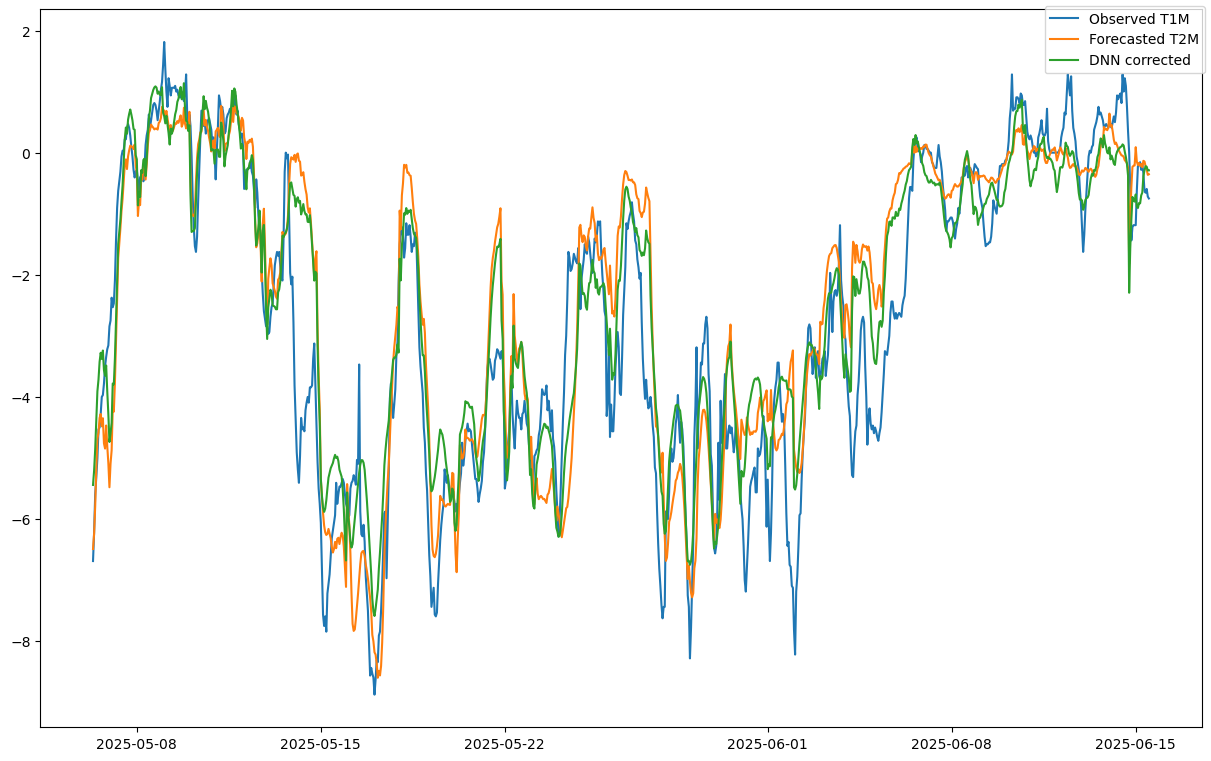

In [ ]:
fig, ax = plt.subplots(figsize = (12, 7.5), constrained_layout = True)

ax.plot(kvs.index, kvs['temp_air'], label = 'Observed T1M')
ax.plot(kvs.index, kvs['arome_t2m'], label = 'Forecasted T2M')
ax.plot(kvs.index, kvs['NN_temp'], label = 'DNN corrected')
ax.plot(kvs.index, kvs['FNN_temp'], label = 'DNN corrected')

fig.legend()